<a href="https://colab.research.google.com/github/nasywafunnisa/pengolahan-citra-digital/blob/main/tugas_model_warna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving objek.avif to objek (1).avif
Gambar berhasil diupload: objek (1).avif
ANALISIS MODEL WARNA – INPUT FOTO UPLOAD

[Terang] Grayscale
  Memori (KB)      : 356.27
  Waktu Uniform ms : 0.43
  Waktu KMeans ms  : 2270.79

[Terang] HSV
  Memori (KB)      : 1068.81
  Waktu Uniform ms : 1.24
  Waktu KMeans ms  : 4760.73

[Terang] LAB
  Memori (KB)      : 1068.81
  Waktu Uniform ms : 1.49
  Waktu KMeans ms  : 4651.05

[Normal] Grayscale
  Memori (KB)      : 356.27
  Waktu Uniform ms : 0.50
  Waktu KMeans ms  : 2435.25

[Normal] HSV
  Memori (KB)      : 1068.81
  Waktu Uniform ms : 1.26
  Waktu KMeans ms  : 5221.22

[Normal] LAB
  Memori (KB)      : 1068.81
  Waktu Uniform ms : 1.61
  Waktu KMeans ms  : 4449.81

[Redup] Grayscale
  Memori (KB)      : 356.27
  Waktu Uniform ms : 0.44
  Waktu KMeans ms  : 2095.49

[Redup] HSV
  Memori (KB)      : 1068.81
  Waktu Uniform ms : 1.18
  Waktu KMeans ms  : 4176.20

[Redup] LAB
  Memori (KB)      : 1068.81
  Waktu Uniform ms : 1.16
  Waktu KMeans ms

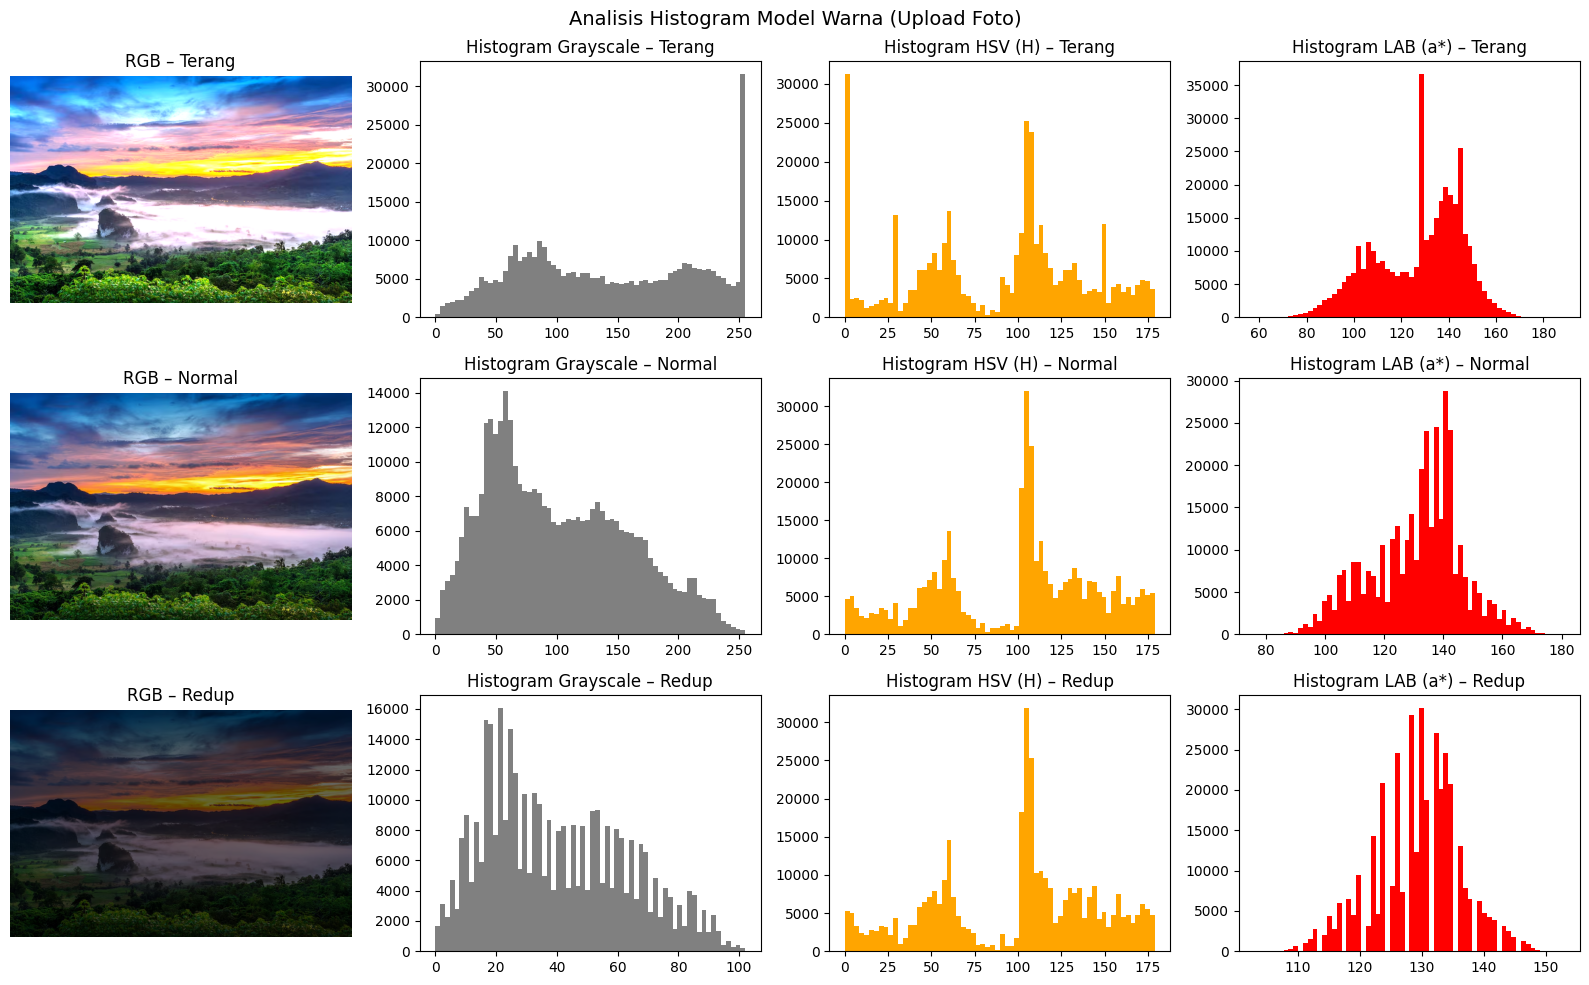

In [4]:
# ============================================================
# Proyek Mini: Konversi Model Warna & Kuantisasi
# ============================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time
from google.colab import files

# ── 1. UPLOAD FOTO ──────────────────────────────────────────
uploaded = files.upload()

# Ambil nama file yang diupload
file_name = list(uploaded.keys())[0]

# Baca gambar dengan OpenCV
file_bytes = np.frombuffer(uploaded[file_name], np.uint8)
img_original = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

if img_original is None:
    raise ValueError("Gambar gagal dibaca!")

print("Gambar berhasil diupload:", file_name)

# ── 2. BUAT VARIASI PENCAHAYAAN (TERANG, NORMAL, REDUP) ─────
def adjust_brightness(img, factor):
    return np.clip(img.astype(np.float32)*factor,0,255).astype(np.uint8)

images = {
    "Terang": adjust_brightness(img_original, 1.5),
    "Normal": img_original,
    "Redup" : adjust_brightness(img_original, 0.4),
}

# ── 3. KONVERSI RUANG WARNA ─────────────────────────────────
def convert_spaces(bgr):
    return {
        "Grayscale": cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY),
        "HSV": cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV),
        "LAB": cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB),
    }

# ── 4. KUANTISASI ───────────────────────────────────────────
def quantize_uniform(img, levels=16):
    step = 256 // levels
    return (img.astype(np.uint16)//step*step).astype(np.uint8)

def quantize_nonuniform(img, k=16):
    sh = img.shape
    flat = img.reshape(-1,1) if img.ndim==2 else img.reshape(-1, sh[2])
    flat = flat.astype(np.float32)

    km = KMeans(n_clusters=k, random_state=42, n_init=5)
    labels = km.fit_predict(flat)
    centers = km.cluster_centers_.astype(np.uint8)

    return centers[labels].reshape(sh)

# ── 5. ANALISIS PARAMETER ───────────────────────────────────
def analyze_params(img, img_name, space_name):
    t0 = time.perf_counter()
    q_uni = quantize_uniform(img,16)
    t_uni = (time.perf_counter()-t0)*1000

    t0 = time.perf_counter()
    q_non = quantize_nonuniform(img,16)
    t_non = (time.perf_counter()-t0)*1000

    print(f"\n[{img_name}] {space_name}")
    print(f"  Memori (KB)      : {img.nbytes/1024:.2f}")
    print(f"  Waktu Uniform ms : {t_uni:.2f}")
    print(f"  Waktu KMeans ms  : {t_non:.2f}")

# ── 6. VISUALISASI HISTOGRAM ────────────────────────────────
def visualize(images):
    fig, axes = plt.subplots(3,4, figsize=(16,10))
    fig.suptitle("Analisis Histogram Model Warna (Upload Foto)", fontsize=14)

    for row, (cond, bgr) in enumerate(images.items()):
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        hsv  = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
        lab  = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)

        # Citra asli
        axes[row,0].imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
        axes[row,0].set_title(f"RGB – {cond}")
        axes[row,0].axis('off')

        # Histogram Grayscale
        axes[row,1].hist(gray.ravel(), bins=64, color='gray')
        axes[row,1].set_title(f"Histogram Grayscale – {cond}")

        # Histogram HSV (Hue)
        axes[row,2].hist(hsv[:,:,0].ravel(), bins=64, color='orange')
        axes[row,2].set_title(f"Histogram HSV (H) – {cond}")

        # Histogram LAB (a*)
        axes[row,3].hist(lab[:,:,1].ravel(), bins=64, color='red')
        axes[row,3].set_title(f"Histogram LAB (a*) – {cond}")

    plt.tight_layout()
    plt.show()

# ── 7. MAIN PROGRAM ─────────────────────────────────────────
print("="*55)
print("ANALISIS MODEL WARNA – INPUT FOTO UPLOAD")
print("="*55)

for cond, img in images.items():
    spaces = convert_spaces(img)
    for name, simg in spaces.items():
        analyze_params(simg, cond, name)

visualize(images)